## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import pickle

# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        write_name = 'after_camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)

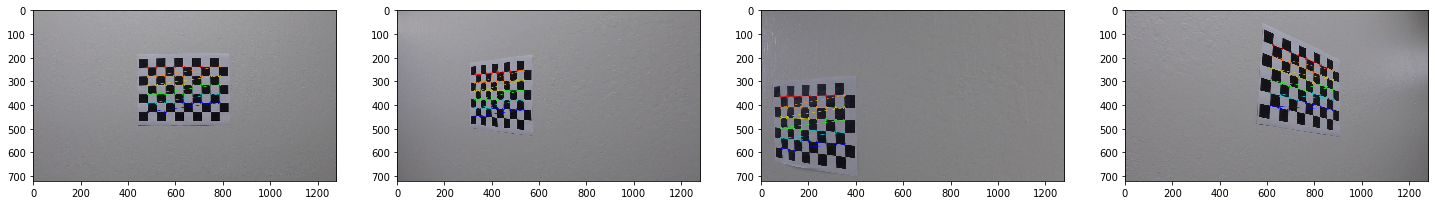

In [3]:
image_names = os.listdir("after_camera_cal/")
plt.figure(figsize=(25,25))
i = 0
# Only show the first 4 results
for image_name in image_names[0:4]:
    image_dir = "after_camera_cal/" + image_name
    image = mpimg.imread(image_dir)
    plt.subplot(5,4,i+1)
    i += 1
    plt.imshow(image)
plt.show()

Text(0.5, 1.0, 'Undistorted Image')

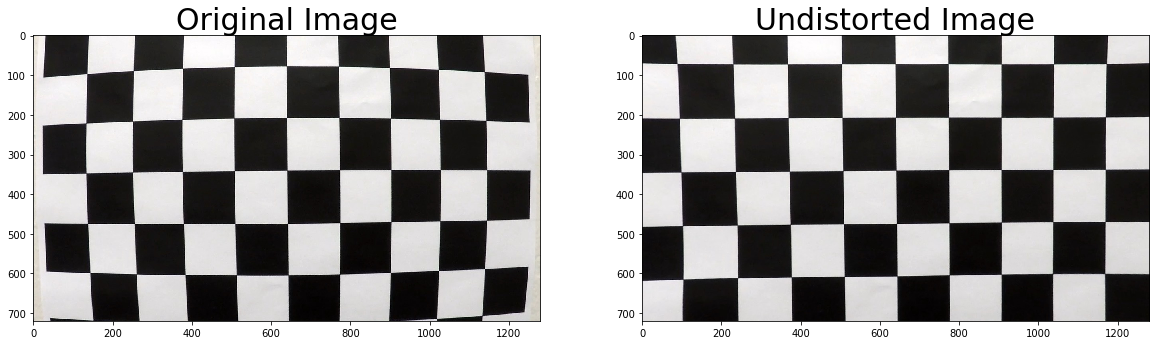

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

# Apply a distortion correction to raw images.

In [ ]:
image_names = os.listdir("test_images/")
plt.figure(figsize=(10,30))
i = 0
for image_name in image_names:
    img = cv2.imread('test_images/'+image_name)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    write_name = 'calibration_wide/'+image_name
    cv2.imwrite(write_name, dst)
    
    plt.subplot(8,2,i+1)
    plt.title('Original Image')
    i += 1
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(8,2,i+1)
    plt.title('Undistorted Image')
    i += 1
    plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()

## Use color transforms, gradients, etc., to create a thresholded binary image.

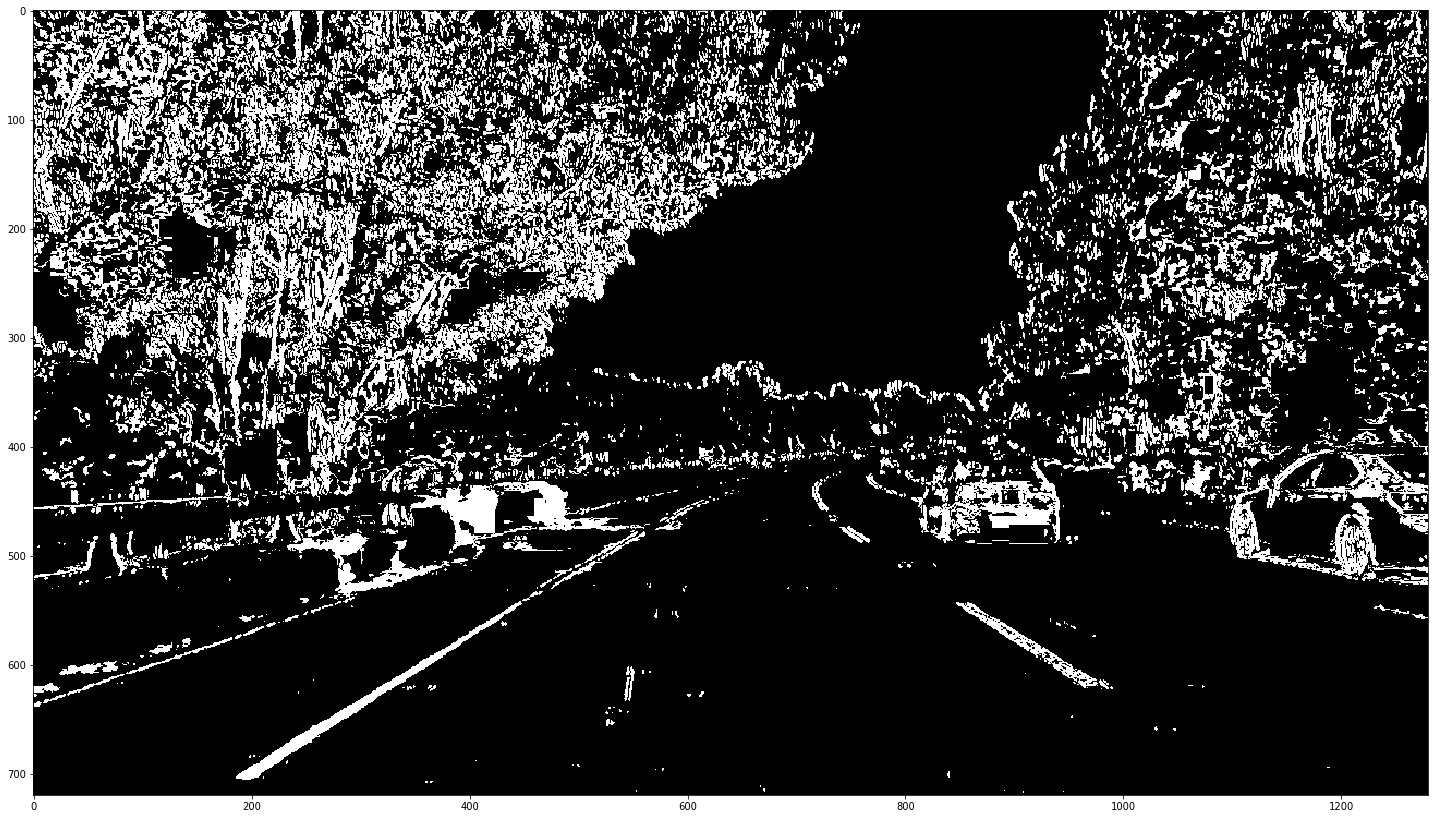

In [67]:
img = mpimg.imread('calibration_wide/test5.jpg')
sx_thresh=(20, 255)
dir_thresh=(np.pi/3, 2*np.pi/3)
s_thresh=(180, 255)

# Convert to HLS color space and separate the V channel
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]
# Sobel x
sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)# Take the derivative in y
# Calculate the gradient magnitude
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

# Take the absolute value of the gradient direction, 
absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
dirbinary =  np.zeros_like(absgraddir)
dirbinary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

# Threshold color channel
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

# Combine the two binary thresholds
combined_binary1 = np.zeros_like(sxbinary)
combined_binary2 = np.zeros_like(sxbinary)
combined_binary1[(sxbinary == 1) & (dirbinary == 1) | (s_binary == 1)] = 1
combined_binary2[(s_binary == 1) | (sxbinary == 1)] = 1
plt.figure(figsize=(25,25))
plt.imshow(combined_binary2, cmap='gray')

In [50]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('calibration_wide/straight_lines1.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary
    
result = pipeline(image)

# Plot the result

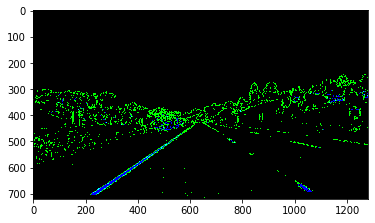

In [51]:
plt.imshow(result)